# Reading and Exploring Dataset of Paper
The objective of the assignment is playing with the dataset and train neural network models with a subset of the dataset.

## Key elements of the paper

The paper "Decoding and geometry of ten finger movements in human posterior parietal cortex and motor cortex" is written by Guan et al. (2023). The study is particularly significant for advancing neural prosthetics by examining how the posterior parietal cortex (PPC) and motor cortex (MC) of tetraplegic participants can decode finger movements.

Two tetraplegic participants were each implanted with a 96-channel array in the left posterior parietal cortex (PPC). One of the participants was additionally implanted with a 96-channel array near the hand knob of the left motor cortex (MC).

2.4. Neural signal recording and preprocessing

Neural signal recording and preprocessing Neural signals were acquired, amplified, bandpassfiltered (0.3 Hz–7.5 kHz) and digitized (30 kHz, 16 bits/sample) from the electrodes using NeuroPort Neural Signal Processors (Blackrock Microsystems Inc.). Action potentials (spikes) were detected by highpass filtering (250 Hz cut-off) the full-bandwidth signal, then thresholding at −3.5 times the root-meansquare voltage of the respective electrode.

2.5. Feature extraction

Except when otherwise specified, we used a 500 millisecond (ms) window of neural activity to calculate firing rates (counted spikes divided by the window duration). The firing rate was then used as the input features to each analysis or classification model. For cross-validation classification analyses, neurons with an average firing rate on the training fold <1 Hz were discarded as noisy features. For singleneuron analyses, a looser threshold of <0.5 Hz, averaged over the entire recording, was used to exclude neurons from significance and effect size tests.

## Libraries

In [1]:
from matplotlib import pyplot as plt
import numpy as np

import elephant.statistics as es
import elephant.kernels as ek
import neo
from pynwb import NWBHDF5IO
import quantities as pq

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

from utils import *

## Access data
The dataset is organized in two folders, one per subject. Subject N1 did two sessions with electrodes in PPC and MC, and subject P1 did 10 sessions with electrode in PPC. Each session is stored in a NWB file, which is a file format to handle complex neurophysiology data.

Folder structure:
```
├── 000252
    ├── sub-N1
    │   ├── sub-N1_ses-2019-02-12_ecephys.nwb
    |   └── sub-N1_ses-2019-02-20_ecephys.nwb
    └── sub-P1
        ├── sub-P1_ses-2015-08-12_ecephys.nwb
        ├── sub-P1_ses-2015-08-14_ecephys.nwb
        ├── ...
        └── sub-P1_ses-2016-05-23_ecephys.nwb

```

The dataset is available here: [https://dandiarchive.org/dandiset/000252](https://dandiarchive.org/dandiset/000252)

### Open NWB File with NWBHDF5IO

In [2]:
# Specify the path to your NWB file
filepath = '000252\sub-P1\sub-P1_ses-2016-05-23_ecephys.nwb'

# Open the NWB file
io = NWBHDF5IO(filepath, 'r')
nwbfile = io.read()

c:\Users\Malik\Desktop\dataset\.venv\Lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
c:\Users\Malik\Desktop\dataset\.venv\Lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
c:\Users\Malik\Desktop\dataset\.venv\Lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


In [3]:
nwbfile

root pynwb.file.NWBFile at 0x1613919936144
Fields:
  devices: {
    NSP1 <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    PPC <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  experiment_description: Intracortical recordings during contralateral/ipsilateral finger movement
  experimenter: ['Tyson Aflalo']
  file_create_date: [datetime.datetime(2023, 4, 8, 14, 43, 34, 12467, tzinfo=tzoffset(None, -25200))]
  identifier: sub-P1_ses-20160523T102211
  institution: California Institute of Technology
  intervals: {
    epochs <class 'pynwb.epoch.TimeIntervals'>,
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  lab: Andersen Lab
  session_description: ten-finger press task, with delay
  session_id: 2016-05-23
  session_start_time: 2016-05-23 10:22:11-07:00
  subject: subject pynwb.file.Subject at 0x1613890447824
Fields:
  age: P25Y/P64Y
  age__reference: birth
  description: tetraplegic woman
  sex: F
  species: Homo sapiens
  subject_id: P1

  timestamps_reference_time: 2016-05-23 10:22:11-07:00
  trials: trials <class 'pynwb.epoch.TimeIntervals'>
  units: units <class 'pynwb.misc.Units'>

### Access Units
The field units contains neural data of each neuron during two observation periods (obs_interval). The spike times correspond to the sequence of spikes (action potentials) produced by a neuron over time.

In [4]:
units = nwbfile.units

units_df = units.to_dataframe()
units_df.head()

,spike_times,obs_intervals,electrodes,electrode_group
id,,,,
0,"[34.75785653333333, 45.9367232, 46.97655653333...","[[23.4036232, 300.15382320000003], [348.776089...",l...,PPC pynwb.ecephys.ElectrodeGroup at 0x16139254...
1,"[23.789256533333333, 25.10275653333333, 25.270...","[[23.4036232, 300.15382320000003], [348.776089...",l...,PPC pynwb.ecephys.ElectrodeGroup at 0x16139254...
2,"[24.159823199999998, 25.508089866666666, 25.54...","[[23.4036232, 300.15382320000003], [348.776089...",l...,PPC pynwb.ecephys.ElectrodeGroup at 0x16139254...
3,"[25.877756533333333, 26.9812232, 25.5144898666...","[[23.4036232, 300.15382320000003], [348.776089...",l...,PPC pynwb.ecephys.ElectrodeGroup at 0x16139254...
4,"[26.6121232, 27.411456533333332, 39.0336232, 3...","[[23.4036232, 300.15382320000003], [348.776089...",l...,PPC pynwb.ecephys.ElectrodeGroup at 0x16139254...


In [5]:
units_df.to_excel('units.xlsx')

In [6]:
num_neurons = units_df.shape[0]
print('Number of neurons:', num_neurons)

Number of neurons: 113


In [7]:
obs_interval = units_df['obs_intervals'][0]
print('Observation interval 1:', obs_interval[0])
print('Observation interval 2:', obs_interval[1])

Observation interval 1: [ 23.4036232 300.1538232]
Observation interval 2: [348.77608987 629.0970232 ]


### Access Trials
The field trials contrains a table with 100 trials. Each trial is given the start_time, stop time, cue_on_time, cue_off_time, and go_on_time, corresponding to the steps in the figure below.


![instructed-delay finger press task](images/figure_1.jpg)

*Each rectangle represents the computer monitor display at each phase. There are two variants: text and spatial. (Guan et al., 2023)*


In [8]:
trials_df = nwbfile.trials.to_dataframe()
trials_df.head()

,Run,TrialNumber,finger,hand,finger_type,start_time,stop_time,cue_on_time,cue_off_time,go_on_time
id,,,,,,,,,,
0,0,1,Lm,L,m,28.046256,31.576256,28.216256,29.316223,30.426256
1,0,2,Li,L,i,31.576256,36.805623,33.166623,34.266456,35.666490
2,0,3,Rr,R,r,36.805623,41.955623,38.395623,39.495623,40.845623
3,0,4,Ri,R,i,41.955623,46.885823,43.545623,44.655623,45.765823
4,0,5,Lp,L,p,46.885823,52.216023,48.475823,49.585823,51.095823


In [9]:
trials_df.to_excel('trials.xlsx')

## Show spike trains and firing rates

Neurons communicate by generating brief electrical impulses called spikes or action potentials. These spikes occur at irregular intervals, and the sequence of these spikes over time is called a spike train.

The firing rate refers to the frequency at which a neuron generates action potentials (spikes) over a given period of time.
- Average firing rate: This is the overall rate calculated by dividing the total number of spikes by the total time period during which the spikes were recorded.
- Instantaneous firing rate: This refers to the firing rate measured at a very short timescale. It can be calculated per bins or with a convolution (rect kernel, gaussian kernel, ...)

Ref: [MIT 9.40 Introduction to Neural Computation](https://www.youtube.com/watch?v=osYGG7TKcz8&list=PL6LqQd8Bju1-KrcOlg6f4QzGBLeSNAs04), Spring 2018, Instructor: Michale Fee

### Different firing rate types

The binned histogram produces a piecewise constant estimate that is dependent on the choice of bin width, resulting in a blocky and possibly noisy estimate of the firing rate.

The instatenous firing rate with kernel convolution produces a smoother, continuous estimate that better represents gradual changes in firing rate, with the flexibility to control the degree of smoothing by adjusting the kernel parameters (e.g., the width of a Gaussian kernel). In general, convolution with a kernel is preferred when a smooth estimate of the firing rate is desired, while binning is often used when simplicity and computational speed are more important.

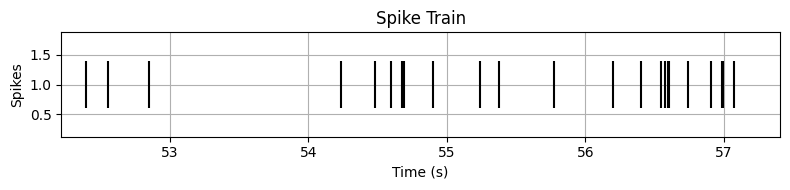

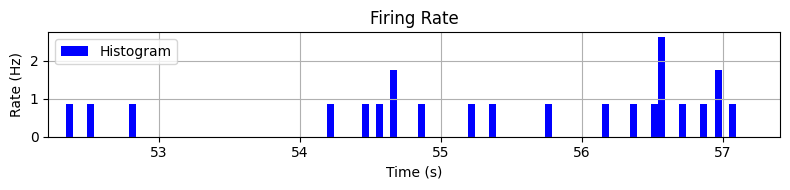

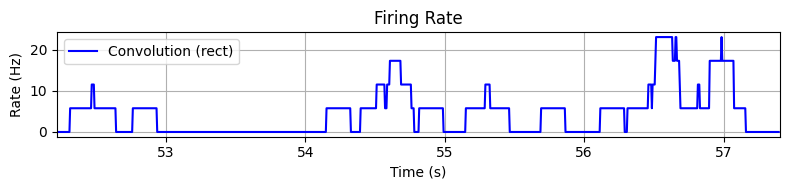

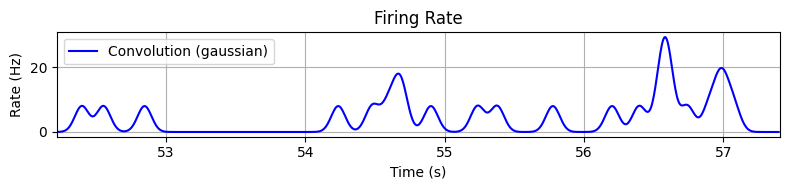

In [10]:
# Plot the spike trains and firing rates of a neuron for one trial
trial_id = 5
neuron_id = 34

window_size = 500*pq.ms
delay = 200*pq.ms

go_time = trials_df.iloc[trial_id]['go_on_time']*pq.s
start_time = trials_df.iloc[trial_id]['start_time']*pq.s
stop_time = trials_df.iloc[trial_id]['stop_time']*pq.s

window = [start_time, stop_time]

spiketrains = calculate_spiketrain_of_interest(units_df, neuron_id, window)
plot_spike_trains(spiketrains, window)

binned_firing_rate = es.time_histogram(spiketrains, binsize=0.05*pq.s, t_start=window[0], t_stop=window[1], output='rate')
plot_binned_firing_rate(binned_firing_rate, window, 0.05*pq.s, 'Histogram')

firing_rate = calculate_firing_rate_of_interest(units_df, neuron_id, window, ek.RectangularKernel(sigma=50*pq.ms))
plot_firing_rate(firing_rate, window, 'Convolution (rect)')

firing_rate = calculate_firing_rate_of_interest(units_df, neuron_id, window, ek.GaussianKernel(sigma=50*pq.ms))
plot_firing_rate(firing_rate, window, 'Convolution (gaussian)')

plt.show()

In [11]:
binned_firing_rate

AnalogSignal with 1 channels of length 103; units 1/s; datatype float64
annotations: {'normalization': 'rate'}
sampling rate: 20.0 1/s
time: 52.216023 s to 57.366023 s

In [12]:
firing_rate

AnalogSignal with 1 channels of length 1037; units Hz; datatype float64
annotations: {'t_stop': array(57.40525633) * s,
  'kernel': {'type': 'GaussianKernel', 'sigma': '50.0 ms', 'invert': False}}
sampling rate: 0.2 1/ms
time: 52.216023 s to 57.401023 s

### Effect of kernel width $\sigma$

We can see on the graphs below the importance of kernel width. It can significantly influence the output signal and choosing the optimal parameters can be subjective.

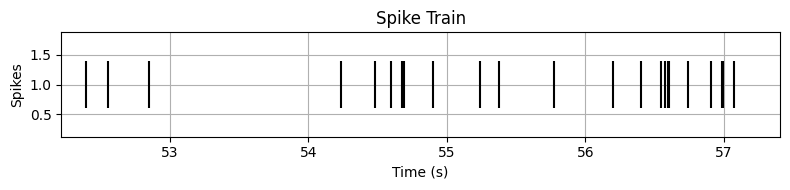

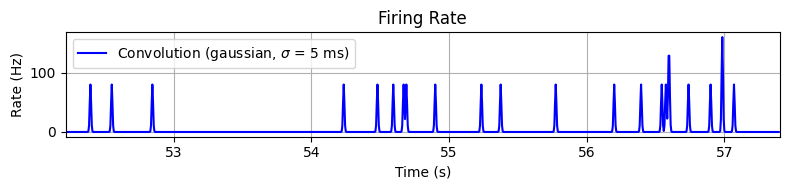

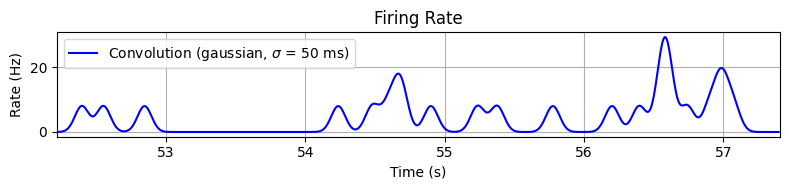

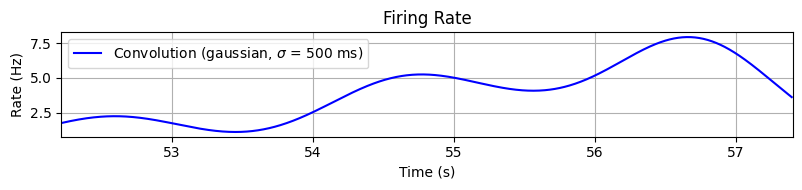

In [13]:
# Plot the spike trains and firing rates of a neuron for one trial
trial_id = 5
neuron_id = 34

start_time = trials_df.iloc[trial_id]['start_time']*pq.s
stop_time = trials_df.iloc[trial_id]['stop_time']*pq.s

window = [start_time, stop_time]

spiketrains = calculate_spiketrain_of_interest(units_df, neuron_id, window)
plot_spike_trains(spiketrains, window)

firing_rate = calculate_firing_rate_of_interest(units_df, neuron_id, window, ek.GaussianKernel(sigma=5*pq.ms))
plot_firing_rate(firing_rate, window, 'Convolution (gaussian, $\sigma$ = 5 ms)')

firing_rate = calculate_firing_rate_of_interest(units_df, neuron_id, window, ek.GaussianKernel(sigma=50*pq.ms))
plot_firing_rate(firing_rate, window, 'Convolution (gaussian, $\sigma$ = 50 ms)')

firing_rate = calculate_firing_rate_of_interest(units_df, neuron_id, window, ek.GaussianKernel(sigma=500*pq.ms))
plot_firing_rate(firing_rate, window, 'Convolution (gaussian, $\sigma$ = 500 ms)')

plt.show()

## Show spike raster

Spike raster show a map with spike trains of all neurons 

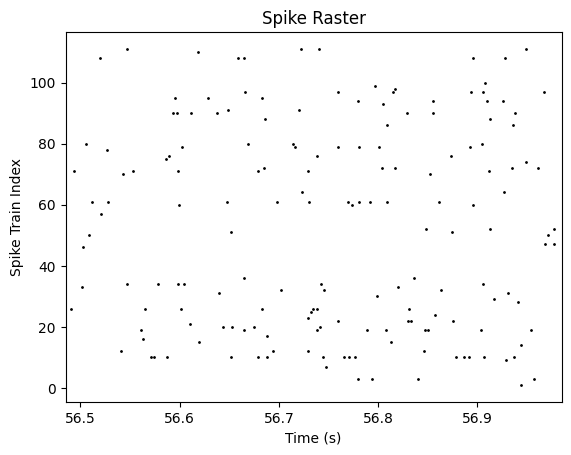

In [14]:
# Define the window size and delay
window_size = 500*pq.ms
delay = 200*pq.ms
bin_size = 5*pq.ms

spiketrain_list = []

trial_id = 5
go_time = trials_df.iloc[trial_id]['go_on_time']*pq.s
window = [go_time+delay, go_time+delay+window_size]

for neuron_id in range(len(units_df)):
    spiketimes = units_df['spike_times'][neuron_id]
    spiketimes_of_interest = spiketimes[(spiketimes >= window[0]) & (spiketimes <= window[1])]
    spiketrain = neo.SpikeTrain(spiketimes_of_interest*pq.s, t_stop=window[1])
    spiketrain_list.append(spiketrain)

plot_spike_raster(spiketrain_list, window)

From spiketrain, we can compute the coefficient of variation. The coefficient of variation is the standard deviation divided by the mean.

C:\Users\Malik\AppData\Local\Temp\ipykernel_5080\3406728552.py:1: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cv_list = [es.cv(es.isi(spiketrain)) for spiketrain in spiketrain_list]


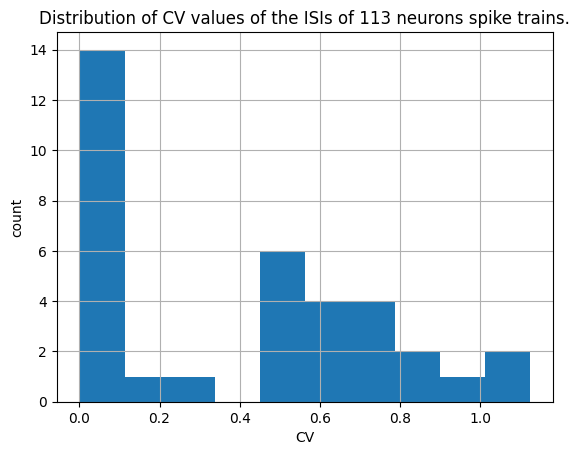

In [15]:
cv_list = [es.cv(es.isi(spiketrain)) for spiketrain in spiketrain_list]

plt.hist(cv_list)
plt.xlabel('CV')
plt.ylabel('count')
plt.title(f'Distribution of CV values of the ISIs of {num_neurons} neurons spike trains.')
plt.grid()
plt.gca().tick_params(axis='both', which='major')
plt.show()

## Prepare dataset

I will run some test with a subset of the dataset. I take only one file of subject P1. The model wil be trained on the right hand data at first. There exists many ways of representing the data to feed the model. We will use the same parameters as in the paper: the firing rate of the spike trains with a Gaussian width of $\sigma$ = 50 ms, and a window size of 500 ms (starting 200 ms after the go time). For the bin size, I choose 5 ms to have a roughly squared input (#neurons = 113, #time_bins=100). The dimensions of the input tensor X is (#trials x #neurons x #time_bins) and the dimensions of output tensor y is (#trials).

To train the model, I divided the training set (80%) and a validation set (20%).


### Training and validation dataset

In [16]:
filepath = '000252\sub-P1\sub-P1_ses-2016-05-23_ecephys.nwb'

# Open the NWB file
io = NWBHDF5IO(filepath, 'r')
nwbfile = io.read()

units = nwbfile.units
units_df = units.to_dataframe()

trials_df = nwbfile.trials.to_dataframe()

c:\Users\Malik\Desktop\dataset\.venv\Lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
c:\Users\Malik\Desktop\dataset\.venv\Lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
c:\Users\Malik\Desktop\dataset\.venv\Lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


In [17]:
# Define the window size and delay
window_size = 500*pq.ms
delay = 200*pq.ms
bin_size = 5*pq.ms

# Define classes
finger_dict = {'Rt':0, 'Ri':1, 'Rm':2, 'Rr':3, 'Rp':4}

# Initialize the matrix to store the firing rates
num_neurons = units_df.shape[0]
num_bins = int(window_size/bin_size)
num_trials = trials_df[trials_df['hand'] == 'R'].shape[0]

X = np.zeros((num_trials, num_neurons, num_bins))  # size (#trials x #neurons x #time_bins)
y = np.zeros((num_trials))  # (1 x #trials)

# Loop through trials of right hand
for i, trial_id in enumerate(trials_df[trials_df['hand'] == 'R'].index):
    go_time = trials_df.iloc[trial_id]['go_on_time']*pq.s
    window = [go_time+delay, go_time+delay+window_size]

    y[i] = finger_dict[trials_df.iloc[trial_id]['finger']]

    # Loop through neurons
    for neuron_id in range(units_df.shape[0]):
        firing_rate = calculate_firing_rate_of_interest(units_df, neuron_id, window, ek.GaussianKernel(sigma=50*pq.ms))
        X[i, neuron_id, :] = np.reshape(firing_rate.magnitude, (1, -1))

In [18]:
# Hyperparameters
batch_size = 8
num_epochs = 50
learning_rate = 0.001

# Assuming you have data in the form of numpy arrays
# X.shape -> (num_trials, num_neurons, num_time_bins)
# y.shape -> (1, num_trials)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a PyTorch dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Classes
classes = ['Rt', 'Ri', 'Rm', 'Rr', 'Rp']

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

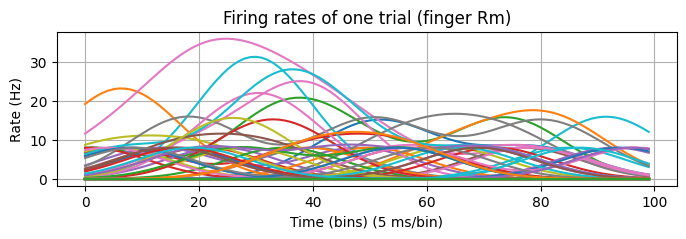

In [19]:
# get some random firing rates
dataiter = iter(train_loader)
data, labels = next(dataiter)

plt.figure(figsize=(8, 2))
plt.grid()

for i in range(data.shape[1]):
    plt.plot(data[1, i, :])

plt.xlabel('Time (bins) (5 ms/bin)')
plt.ylabel('Rate (Hz)')
plt.title(f'Firing rates of one trial (finger {classes[labels[1].item()]})')
plt.show()

## Train CNN model

In [20]:
from model import NeuralDecodingCNN

# Model, Loss function, and Optimizer
num_classes = len(classes)

model = NeuralDecodingCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [21]:
# Training loop with tracking
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Store loss and accuracy
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        model.train()

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total * 100

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        running_vloss = 0.0
        correct_val = 0
        total_val = 0

        model.eval()

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_vloss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_vloss / len(val_loader)
        val_accuracy = correct_val / total_val * 100

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Run the training
train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)


Epoch [1/50], Train Loss: 1.7562, Train Acc: 10.00%, Val Loss: 1.7495, Val Acc: 20.00%
Epoch [2/50], Train Loss: 1.6005, Train Acc: 30.00%, Val Loss: 1.7441, Val Acc: 20.00%
Epoch [3/50], Train Loss: 1.6616, Train Acc: 25.00%, Val Loss: 1.8423, Val Acc: 10.00%
Epoch [4/50], Train Loss: 1.6039, Train Acc: 30.00%, Val Loss: 1.8423, Val Acc: 10.00%
Epoch [5/50], Train Loss: 1.6548, Train Acc: 25.00%, Val Loss: 1.8423, Val Acc: 10.00%
Epoch [6/50], Train Loss: 1.6798, Train Acc: 22.50%, Val Loss: 1.8423, Val Acc: 10.00%
Epoch [7/50], Train Loss: 1.6798, Train Acc: 22.50%, Val Loss: 1.8423, Val Acc: 10.00%
Epoch [8/50], Train Loss: 1.6798, Train Acc: 22.50%, Val Loss: 1.8423, Val Acc: 10.00%
Epoch [9/50], Train Loss: 1.6798, Train Acc: 22.50%, Val Loss: 1.8423, Val Acc: 10.00%
Epoch [10/50], Train Loss: 1.6798, Train Acc: 22.50%, Val Loss: 1.8423, Val Acc: 10.00%
Epoch [11/50], Train Loss: 1.6798, Train Acc: 22.50%, Val Loss: 1.8423, Val Acc: 10.00%
Epoch [12/50], Train Loss: 1.6798, Train 

### Results of CNN model

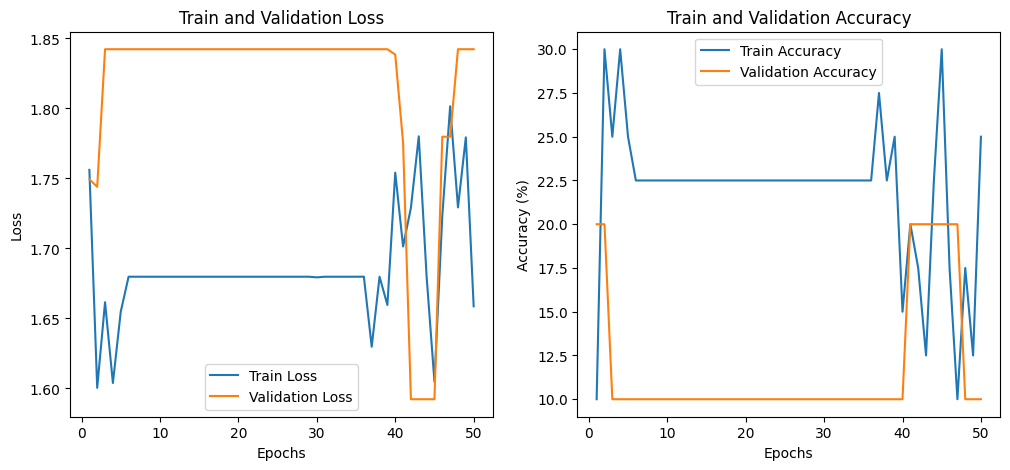

In [22]:
# Plotting loss and accuracy
epochs = range(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()

The model does not learn anything form the dataset. The accuracy stays under 50% for train and valid set. I am surprised because the dataset is so small I would have expected the model to overfit the data.

To have a better idea of the performance of the model, we would need to train on a bigger dataset. Or maybe check if there are not mistake in the model itself.

## Train RNN model

The second approach is to train a RNN model. 

In [23]:
def train_rnn(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            # Reshape inputs for LSTM (batch_size, sequence_length, input_size)
            inputs = inputs.permute(0, 2, 1)  # Change shape to (batch_size, time_bins, num_neurons)
            
            outputs = model(inputs)  # Shape (batch_size, num_classes)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total * 100
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.permute(0, 2, 1)  # Change shape to (batch_size, time_bins, num_neurons)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val * 100
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [24]:
# Hyperparameters
batch_size = 8
num_epochs = 50
learning_rate = 0.001

In [25]:
from model import NeuralDecodingRNN

input_size = num_neurons  # Number of neurons
hidden_size = 64  # Can be adjusted
num_layers = 2    # Can be adjusted
num_classes = len(classes)   # Number of classe

model = NeuralDecodingRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Assuming train_loader and val_loader are already defined
train_losses, val_losses, train_accuracies, val_accuracies = train_rnn(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

Epoch [1/50], Train Loss: 1.6119, Train Acc: 17.50%, Val Loss: 1.6073, Val Acc: 30.00%
Epoch [2/50], Train Loss: 1.5912, Train Acc: 47.50%, Val Loss: 1.6060, Val Acc: 30.00%
Epoch [3/50], Train Loss: 1.5719, Train Acc: 77.50%, Val Loss: 1.6057, Val Acc: 40.00%
Epoch [4/50], Train Loss: 1.5463, Train Acc: 97.50%, Val Loss: 1.6059, Val Acc: 20.00%
Epoch [5/50], Train Loss: 1.5041, Train Acc: 100.00%, Val Loss: 1.6078, Val Acc: 10.00%
Epoch [6/50], Train Loss: 1.4375, Train Acc: 100.00%, Val Loss: 1.6113, Val Acc: 30.00%
Epoch [7/50], Train Loss: 1.3347, Train Acc: 100.00%, Val Loss: 1.6129, Val Acc: 30.00%
Epoch [8/50], Train Loss: 1.2138, Train Acc: 100.00%, Val Loss: 1.6238, Val Acc: 40.00%
Epoch [9/50], Train Loss: 1.1026, Train Acc: 100.00%, Val Loss: 1.6217, Val Acc: 40.00%
Epoch [10/50], Train Loss: 1.0246, Train Acc: 100.00%, Val Loss: 1.6025, Val Acc: 40.00%
Epoch [11/50], Train Loss: 0.9771, Train Acc: 100.00%, Val Loss: 1.5466, Val Acc: 50.00%
Epoch [12/50], Train Loss: 0.9531,

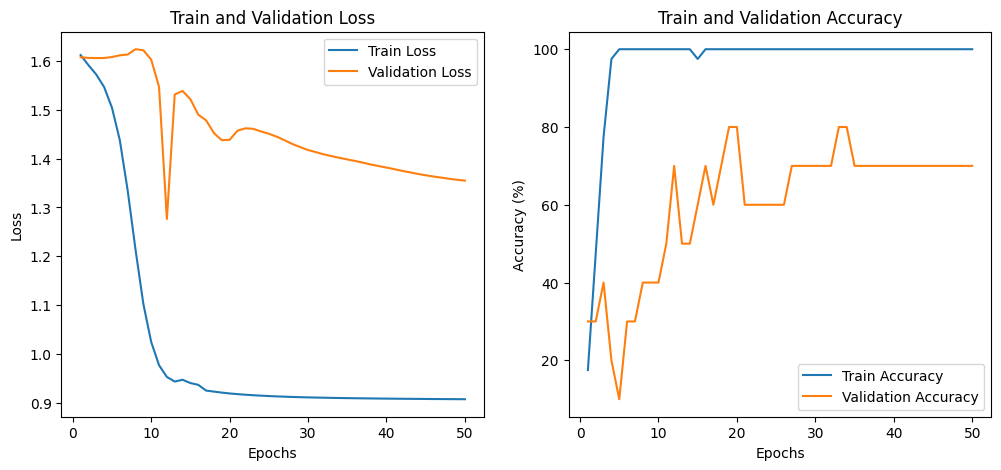

In [26]:
# Plotting loss and accuracy
epochs = range(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()

### Results of RNN model

The figure shows a low training loss and high validation loss which show that the model overfits the data. The training accuracy is too high (100 %), but the validation accuracy stays under 50 % which show overfitting of the data as well.

To improve the results, we should train the model on the whole dataset. If the dataset is not big enough to do deep learning, data augmentation is a solution. Adding dropout layer cannot help to reduce overfitting as well.

## RNN vs CNN model
RNN model performance are better suited to analyze temporal and sequential data. They feed results back into the network during the training. The data we analyze in this paper is the firing rates of neurons generated by a person trying to move a finger. Since it is temporal data, this could explain why RNN model performs better than CNN model.

Training a model for a small subset of dataset is a method to evaluate the sanity of a model. If the model overfits, it means that it will be possible to train the model on bigger data and get some results. It the model does not learn, it means that there is a problem to solve before moving to real dataset.

## Discussion

**Number neurons is not constant across sessions**  
When I analyze the field electrodes, I see that there is only one electrode group (NSP1 pynwb.device.Device at 0x2873006297552) for 96 rows of the dataframe. Since subject P1 is implanted with a 96-channel array in the left posterior parietal cortex (PPC), I suppose that it corresponds to the 96 channels of the electode.

When I analyze the field units (with the spike train of each neurons), the number of neurons is not constant across different sessions. It varies between 102 and 119 for subject P1. The number of neurons is not constant as I would have expected. It could be explained if it is not a fix implant and at each session they have to reimplant the electrode in the PPC.

In that scenario it is perhaps better to make an average over neurons (because the neuron_id will not be consistant across different sessions). That would mean that the finger classification would only depend on global neuron activation across time and not on which neurons activate when (space).

Is the objective to know which neuron are related to which finger ? Or to link the average firing rate of all neurons to a finger ? (some finger could have a smaller global firing rate than other, but I have the feeling that it would not be sufficient information to classify the fingers). If the neuron ID do not match across session, it would be better to make an average across neurons but we would loose information about how the neurons activate in the space.

**Model generalization**  
Is the objective to train a general model to decode any brain in general or is it necessary to train a model per subject because every person will have different neuronal response ?

**Other ideas**  
It could be interesting to explore other dataset form than firing rates. Maybe spike raster could work better with CNN because the data is more linked in the space. However, I think CNN is not a good approach because we dont have the neuron map in space. It means that the order into which we put the neurons probably do not make sense (mabye neuron 45 and neuron 83) are linked in brain space and not in 2D image we build with neuron in order form 0 to #neurons. One avantage of 2d convolution is to gain information from the close neighborhood.

It would also be relevant to explore other RNN architecture, or transfomers. For this assignments, I used very simple model.